In [30]:
import torch
from transformers import SegformerFeatureExtractor
import sys
sys.path.insert(1, '../utils/')
import os
import numpy as np

In [31]:
from create_dataloaders import EddyDatasetTrain, EddyDatasetValid

In [32]:
feature_extractor = SegformerFeatureExtractor.from_pretrained("nvidia/segformer-b0-finetuned-ade-512-512")
feature_extractor.reduce_labels = False
feature_extractor.size = 128

/home/emir/anaconda3/envs/emirenv/lib/python3.10/site-packages/transformers/models/segformer/image_processing_segformer.py:102: FutureWarning: The `reduce_labels` parameter is deprecated and will be removed in a future version. Please use `do_reduce_labels` instead.
  warnings.warn(


In [33]:
input_image_dir = "/home/emir/dev/segmentation_eddies/downloads/data4test/aug_data/"
mask_image_dir = "/home/emir/dev/segmentation_eddies/downloads/data4test/aug_label/"
val_image_dir = "/home/emir/dev/segmentation_eddies/downloads/data4test/data/"
val_mask_dir = "/home/emir/dev/segmentation_eddies/downloads/data4test/label/"

In [34]:
train_len = len(os.listdir(input_image_dir))
split = int(0.85 * train_len)

In [35]:
train_data = EddyDatasetTrain(feature_extractor=feature_extractor, input_image_dir=input_image_dir, mask_image_dir=mask_image_dir, split=split)
valid_data = EddyDatasetValid(feature_extractor=feature_extractor, input_image_dir=val_image_dir, mask_image_dir=val_mask_dir, split=split)

In [36]:
len(train_data), len(valid_data)

(9180, 1620)

In [37]:
import matplotlib.pyplot as plt

In [38]:
def visualize_train_data(data):
    rand_ind = np.random.randint(len(train_data))
    fig = plt.figure(figsize=(15, 10))
    rows = 1
    columns = 2
    fig.add_subplot(rows, columns, 1)
    plt.imshow((data[rand_ind]['pixel_values']).permute(1,2,0))
    plt.axis(False)
    plt.title("Image")
    fig.add_subplot(rows, columns, 2)
    plt.imshow((data[rand_ind]['labels']))
    plt.axis(False)
    plt.title("Label")


In [39]:
train_data[0]['labels'].shape

torch.Size([128, 128])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


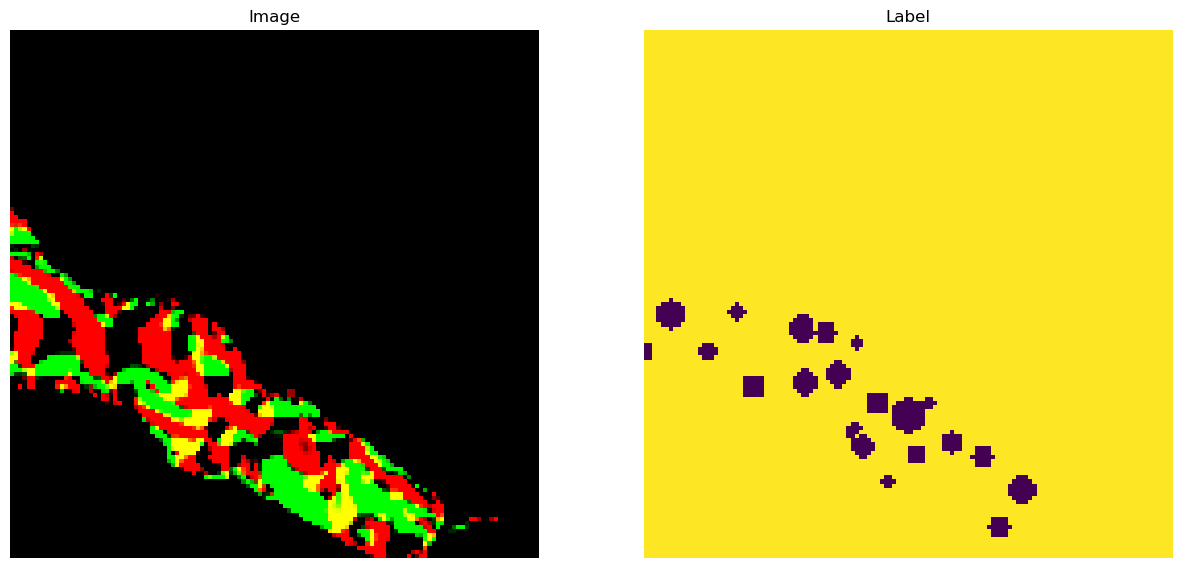

In [40]:
visualize_train_data(train_data)

In [41]:
from torch.utils.data import DataLoader

train_dataloader = DataLoader(train_data, batch_size=32, shuffle=True)
valid_dataloader = DataLoader(valid_data, batch_size=32, shuffle=False)

In [42]:
len(train_dataloader)

287

In [43]:
feature_extractor

SegformerImageProcessor {
  "do_normalize": true,
  "do_reduce_labels": true,
  "do_rescale": true,
  "do_resize": true,
  "feature_extractor_type": "SegformerFeatureExtractor",
  "image_mean": [
    0.485,
    0.456,
    0.406
  ],
  "image_processor_type": "SegformerImageProcessor",
  "image_std": [
    0.229,
    0.224,
    0.225
  ],
  "reduce_labels": false,
  "resample": 2,
  "rescale_factor": 0.00392156862745098,
  "size": 128
}

In [44]:
pretrained_weights = "nvidia/segformer-b0-finetuned-ade-512-512"

In [45]:
import pytorch_lightning as pl
from datasets import load_metric
import torch
from torch import nn

In [46]:
from transformers import SegformerForSemanticSegmentation

In [47]:
from transformers import SegformerForSemanticSegmentation
import json
from huggingface_hub import cached_download, hf_hub_url

# load id2label mapping from a JSON on the hub
repo_id = "huggingface/label-files"
filename = "ade20k-id2label.json"
id2label = json.load(open(cached_download(hf_hub_url(repo_id, filename, repo_type='dataset')), "r"))
id2label = {int(k): v for k, v in id2label.items()}
label2id = {v: k for k, v in id2label.items()}

# define model
model = SegformerForSemanticSegmentation.from_pretrained("nvidia/mit-b0",
                                                         num_labels=150, 
                                                         id2label=id2label, 
                                                         label2id=label2id,
)

/home/emir/anaconda3/envs/emirenv/lib/python3.10/site-packages/huggingface_hub/file_download.py:594: FutureWarning: `cached_download` is the legacy way to download files from the HF hub, please consider upgrading to `hf_hub_download`
  warnings.warn(
Some weights of the model checkpoint at nvidia/mit-b0 were not used when initializing SegformerForSemanticSegmentation: ['classifier.bias', 'classifier.weight']
- This IS expected if you are initializing SegformerForSemanticSegmentation from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing SegformerForSemanticSegmentation from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of SegformerForSemanticSegmentation were not initialized from the model chec

In [48]:
from datasets import load_metric

metric = load_metric("mean_iou")

In [49]:
def train_segformer(model, train_dataloader, optimizer, device, epochs, metric):
  model.to(device)

  model.train()
  for epoch in range(epochs):  # loop over the dataset multiple times
    print("Epoch:", epoch)
    for idx, batch in enumerate((train_dataloader)):
          # get the inputs;
          pixel_values = batch["pixel_values"].to(device)
          labels = batch["labels"].to(device)

          # zero the parameter gradients
          optimizer.zero_grad()

          # forward + backward + optimize
          outputs = model(pixel_values=pixel_values, labels=labels)
          loss, logits = outputs.loss, outputs.logits # no loss function declared model calculates itself
          
          loss.backward()
          optimizer.step()

          # evaluate
          with torch.no_grad():
            upsampled_logits = nn.functional.interpolate(logits, size=labels.shape[-2:], mode="bilinear", align_corners=False)
            predicted = upsampled_logits.argmax(dim=1)
            
            # note that the metric expects predictions + labels as numpy arrays
            metric.add_batch(predictions=predicted.detach().cpu().numpy(), references=labels.detach().cpu().numpy())

          # let's print loss and metrics every 100 batches
          if idx % 100 == 0:
            metrics = metric._compute(num_labels=len(id2label), 
                                    ignore_index=255,
                                    reduce_labels=False,
                                    references=labels.cpu().numpy(),
                                    predictions=predicted.cpu().numpy()
                                      # we've already reduced the labels before)
            )

            print("Loss:", loss.item())
            print("Mean_iou:", metrics["mean_iou"])
            print("Mean accuracy:", metrics["mean_accuracy"])

In [50]:
optimizer = torch.optim.AdamW(model.parameters(), lr=0.00006)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [51]:
train_segformer(model=model, train_dataloader=train_dataloader, metric=metric, optimizer=optimizer, device=device, epochs=100)


Epoch: 0


/home/emir/.cache/huggingface/modules/datasets_modules/metrics/mean_iou/d4add40cf977cdd73590b5873fa830f3f13adb678f6777a29fb07b7c81d14342/mean_iou.py:258: RuntimeWarning: invalid value encountered in divide
  iou = total_area_intersect / total_area_union
/home/emir/.cache/huggingface/modules/datasets_modules/metrics/mean_iou/d4add40cf977cdd73590b5873fa830f3f13adb678f6777a29fb07b7c81d14342/mean_iou.py:259: RuntimeWarning: invalid value encountered in divide
  acc = total_area_intersect / total_area_label


Loss: 5.121739864349365
Mean_iou: 0.0
Mean accuracy: 0.0
Loss: 3.4804975986480713
Mean_iou: 0.013174444879763773
Mean accuracy: 0.8265348553461647
Loss: 2.217844009399414
Mean_iou: 0.12366023303325505
Mean accuracy: 0.7268699954352695
Epoch: 1
Loss: 1.3992747068405151
Mean_iou: 0.5718218505692287
Mean accuracy: 0.6328798929339253
Loss: 0.6970198750495911
Mean_iou: 0.6539935341590379
Mean accuracy: 0.7154603982169522
Loss: 0.36103686690330505
Mean_iou: 0.5399551555851334
Mean accuracy: 0.5479140279732608
Epoch: 2
Loss: 0.25978508591651917
Mean_iou: 0.623791457671568
Mean accuracy: 0.6548506226673608
Loss: 0.18022280931472778
Mean_iou: 0.642451436009035
Mean accuracy: 0.6642187406842721
Loss: 0.13232490420341492
Mean_iou: 0.6150218925372442
Mean accuracy: 0.6299415108279228
Epoch: 3
Loss: 0.09934397786855698
Mean_iou: 0.640383764550135
Mean accuracy: 0.6604214362052497
Loss: 0.09231345355510712
Mean_iou: 0.6161383018597628
Mean accuracy: 0.6280338939955527
Loss: 0.08211514353752136
Mean_

KeyboardInterrupt: 

In [55]:
save_path = "./output/model.pth"

torch.save(model.state_dict(), save_path)

In [59]:
len(valid_data)

1620

In [102]:
def predict_random_image(model, data, device, feature_extractor):
    rand_ind = np.random.randint(len(data))
    img = data[rand_ind]['pixel_values'].to(device)
    mask = data[rand_ind]['labels'].to(device)
    print(img.shape[::-1])
    encoding = feature_extractor(img, return_tensors="pt")
    pix = encoding.pixel_values.to(device)
    outputs = model(pixel_values=pix)
    logits = outputs.logits.cpu()
    up_logit = nn.functional.interpolate(logits, size=img.shape[-2:], mode='bilinear', align_corners=False)
    seg = up_logit.argmax(dim=1)[0]
    fig = plt.figure(figsize=(10, 7))
    rows = 1
    columns = 3
    fig.add_subplot(rows, columns, 1)
    plt.imshow(img.cpu().permute(1,2,0))
    plt.axis(False)
    plt.title("Input Data")
    fig.add_subplot(rows, columns, 2)
    plt.imshow(seg)
    plt.axis(False)
    plt.title("Predicted Label")
    fig.add_subplot(rows, columns, 3)
    plt.imshow(mask.cpu())
    plt.axis(False)
    plt.title("Actual Label")
    
    
    

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([128, 128, 3])


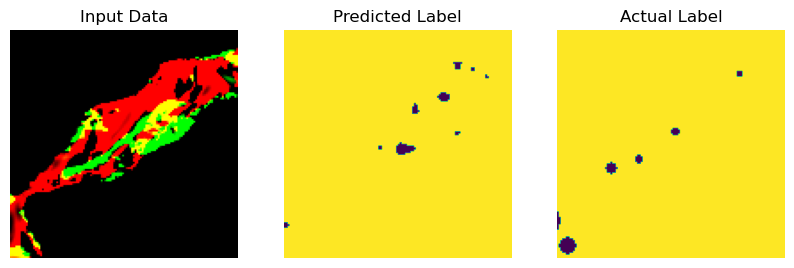

In [114]:
predict_random_image(model=model, data=valid_data, device=device, feature_extractor=feature_extractor)